In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

from keras.models import Sequential
from keras.layers import InputLayer, Bidirectional, LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.constraints import MaxNorm
from keras.callbacks import ModelCheckpoint

import time

In [2]:
filepath = 'C:/Users/ss230/Documents/Study/NSIDC/Edited Data/N_Sea_Ice_Index_Regional_Monthly_Data_G02135_v3.0.xlsx'
Kara = pd.read_excel(filepath, sheet_name='Kara-Extent-km^2')

In [3]:
import sys
sys.path.append('C:/Users/ss230/Documents/Study/NSIDC/NH/')
import Function as fp

In [4]:
fp.month_mapping(Kara)
fp.date_time(Kara)

,Extent,Date
0,917992.880,1979-01-01
1,917992.880,1979-02-01
2,917992.880,1979-03-01
3,917992.880,1979-04-01
4,917992.880,1979-05-01
...,...,...
533,728642.743,2023-06-01
534,437024.646,2023-07-01
535,202260.789,2023-08-01
536,98103.856,2023-09-01


In [5]:
scaler = MinMaxScaler()
Kara['Extent'] = scaler.fit_transform(Kara['Extent'].values.reshape(-1, 1))

In [6]:
def df_to_X_y(df, window_size):
    df_as_np = df.to_numpy()
    X = []
    y = []
    lead_time = 4
    for i in range(len(df_as_np) - window_size - lead_time + 1):
        window_data = df_as_np[i:i+window_size]
        row = [[a] for a in window_data]
        X.append(row)
        label = df_as_np[i+window_size+lead_time-1]
        y.append(label)
    return np.array(X), np.array(y)

In [7]:
extent = Kara['Extent']
W_S=12
X,y = df_to_X_y(extent, W_S)
X.shape, y.shape

((523, 12, 1), (523,))

In [8]:
X_train, y_train = X[:420], y[:420]
X_val, y_val = X[420:472], y[420:472]
X_test, y_test = X[472:], y[472:]

In [9]:
model = Sequential()
model.add(InputLayer((W_S, 1)))
model.add(Bidirectional(LSTM(128, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(64, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(32, activation='relu', kernel_constraint=MaxNorm(1.0))))
model.add(Dense(1, activation='linear'))

cp = ModelCheckpoint('Kara_model_LT4/', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(0.0001), metrics=[RootMeanSquaredError()])

In [10]:
stime = time.time()
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=8, callbacks=[cp])
etime = time.time()

Epoch 1/50
53/53 [==============================] - 53s 689ms/step - loss: 0.4874 - root_mean_squared_error: 0.6982 - val_loss: 0.2282 - val_root_mean_squared_error: 0.4777
Epoch 2/50
53/53 [==============================] - 39s 749ms/step - loss: 0.1091 - root_mean_squared_error: 0.3303 - val_loss: 0.1325 - val_root_mean_squared_error: 0.3640
Epoch 3/50
53/53 [==============================] - 33s 633ms/step - loss: 0.0759 - root_mean_squared_error: 0.2754 - val_loss: 0.1136 - val_root_mean_squared_error: 0.3371
Epoch 4/50
53/53 [==============================] - 34s 650ms/step - loss: 0.0684 - root_mean_squared_error: 0.2614 - val_loss: 0.0959 - val_root_mean_squared_error: 0.3097
Epoch 5/50
53/53 [==============================] - 39s 750ms/step - loss: 0.0599 - root_mean_squared_error: 0.2447 - val_loss: 0.0790 - val_root_mean_squared_error: 0.2811
Epoch 6/50
53/53 [==============================] - 46s 879ms/step - loss: 0.0524 - root_mean_squared_error: 0.2289 - val_loss: 0.0674 

53/53 [==============================] - 26s 503ms/step - loss: 0.0278 - root_mean_squared_error: 0.1668 - val_loss: 0.0261 - val_root_mean_squared_error: 0.1617
Epoch 28/50
53/53 [==============================] - 27s 514ms/step - loss: 0.0267 - root_mean_squared_error: 0.1633 - val_loss: 0.0253 - val_root_mean_squared_error: 0.1590
Epoch 29/50
53/53 [==============================] - 2s 46ms/step - loss: 0.0264 - root_mean_squared_error: 0.1624 - val_loss: 0.0273 - val_root_mean_squared_error: 0.1651
Epoch 30/50
53/53 [==============================] - 25s 489ms/step - loss: 0.0252 - root_mean_squared_error: 0.1587 - val_loss: 0.0246 - val_root_mean_squared_error: 0.1567
Epoch 31/50
53/53 [==============================] - 2s 46ms/step - loss: 0.0245 - root_mean_squared_error: 0.1565 - val_loss: 0.0287 - val_root_mean_squared_error: 0.1693
Epoch 32/50
53/53 [==============================] - 26s 494ms/step - loss: 0.0228 - root_mean_squared_error: 0.1510 - val_loss: 0.0238 - val_root

In [11]:
time = (etime - stime)/60
print(f'{time} minutes')

19.06168950398763 minutes


In [12]:
loss = history.history['loss']
epochs = list(range(1, len(loss) + 1))

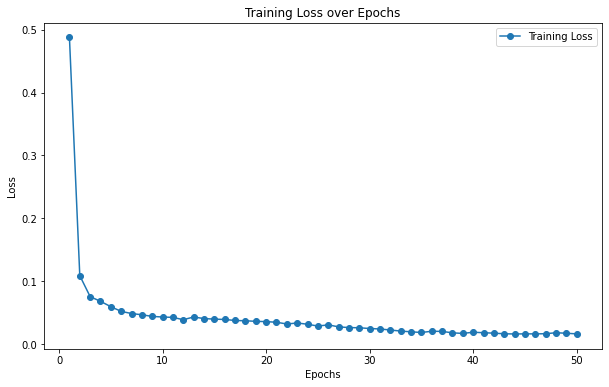

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, label='Training Loss', marker='o', linestyle='-')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

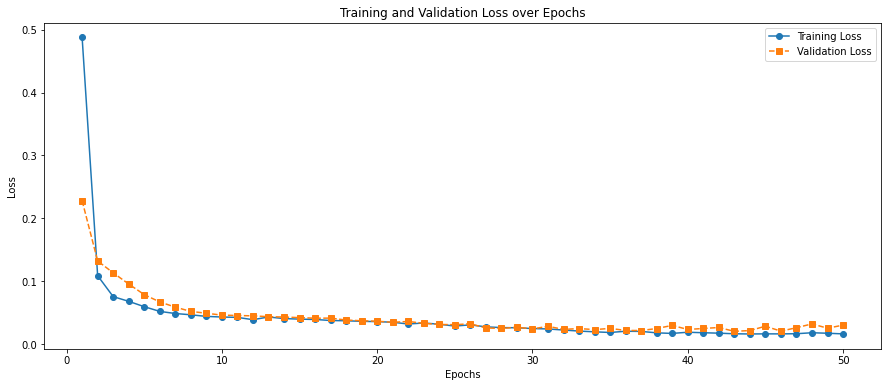

In [14]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1, len(training_loss) + 1)

plt.figure(figsize=(15,6))
plt.plot(epochs, training_loss, label='Training Loss', marker='o', linestyle='-')
plt.plot(epochs, validation_loss, label='Validation Loss', marker='s', linestyle='--')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

In [15]:
from tensorflow.keras.models import load_model
model1 = load_model('Kara_model_LT4/')

In [16]:
test_predictions = model1.predict(X_test)

2/2 [==============================] - 2s 42ms/step


In [17]:
mse = mean_squared_error(y_test, test_predictions)
print('RMSE :', np.sqrt(mse))

mae = mean_absolute_error(y_test, test_predictions)
print('MAE :', mae)

RMSE : 0.13551487994988054
MAE : 0.08985303286633073


In [18]:
test_predictions = scaler.inverse_transform(test_predictions)
test_original = scaler.inverse_transform(y_test.reshape(-1,1))

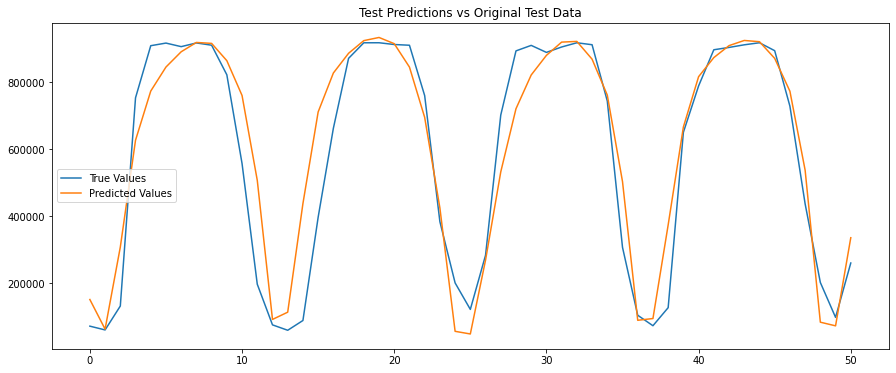

In [19]:
plt.figure(figsize=(15,6))
plt.plot(test_original, label='True Values')
plt.plot(test_predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()

In [20]:
predictions = model1.predict(X)

17/17 [==============================] - 1s 38ms/step


In [21]:
predictions = scaler.inverse_transform(predictions)
Original = scaler.inverse_transform(y.reshape(-1,1))

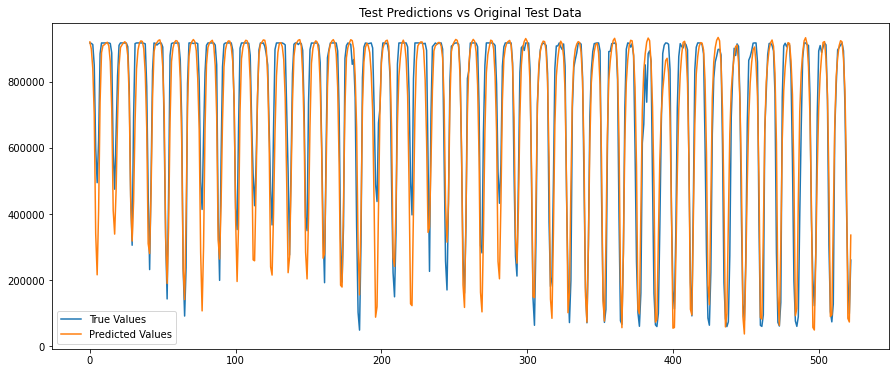

In [22]:
plt.figure(figsize=(15,6))
plt.plot(Original, label='True Values')
plt.plot(predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()